### First attempt 

This notebook constitutes the first attempt of the following approach. In accordance to ideas, the main aim is to train filters(kernels) of a convolutional neural network for classification data on CIFAR 100. This first attempt will follow to the plan.

1.   Obtain Source Kernel Distribution(SKD) by training the CNN on CIFAR 10.
2.   Take the CNN with unlearned kernels for classification of CIFAR 100 data.
3.   During the some iterations one should train filters of CNN by SGD (loss missclassification minimize by $\omega$(kernels))
4.   Take a untrained discriminator $\mathbb{D}$ and this network will try to distinguish $\omega$ (as fake) and $\omega_{SKD}$ (as real) by learning parameters of Discriminator.
5.   At the same time one can try to perplex the $\mathbb{D}$ via the following expression: $$ log \mathbb{D} (\omega)  \rightarrow \min_{\omega} $$
6.  Take this new more optimized filters and fit to CNN and will steps 4-5, but with more trained $\mathbb{D}$



In [1]:
import torch
import torchvision


from IPython.display import clear_output
import time
import tqdm
from tqdm import tqdm_notebook
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.cuda.is_available()

True

### 1. Obtain Source Kernel Distribution (SKD)

In [4]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False, transform=torchvision.transforms.ToTensor(),download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000,10000])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
def plot_learning_curves(history):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)

    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='validation')

    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='validation')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()
    plt.show()

Let me define the following simple convolutional network that has to classify images of CIFAR100  finally, however we are going to train it on CIFAR 10 to get SKD  now.

The convolutional network is composed of 2 layers 

1.   1 layer: 32 * 3 filters with  size 3x3
2.   2 layer: 64*32 filters with size 3x3



In [8]:
class SimpleConvNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = torch.nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 3) 
    self.mp1 = torch.nn.MaxPool2d(kernel_size = 2)
    self.bn1 = torch.nn.BatchNorm2d(32)
    self.droupout1 = torch.nn.Dropout(0.3)
    self.relu1 = torch.nn.ReLU()
    # [batch,32,15,15]
        
    self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.mp2 = torch.nn.MaxPool2d(kernel_size=2)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.droupout2 = torch.nn.Dropout(0.3)
    self.relu2 = torch.nn.ReLU()
    #[batch,64,6,6]
        
    self.flatten = torch.nn.Flatten()
    self.fc3 = torch.nn.Linear(64*6*6, 512)
    self.droupout3 = torch.nn.Dropout(0.3)
    self.relu3 = torch.nn.ReLU()
    self.fc4 = torch.nn.Linear(512, 10)

  def forward(self, x):
    layer1 = self.mp1(self.conv1(x))
    layer1 = self.relu1(self.droupout1(self.bn1(layer1)))
        
    layer2 = self.mp2(self.conv2(layer1))
    layer2 = self.relu2(self.droupout2(self.bn2(layer2)))
        
    out = self.flatten(layer2)
    out = self.relu3(self.droupout3(self.fc3(out)))
    out = self.fc4(out)
    return out # [batch,10] i.e. batch of logits

Right now, one can train this convolutional neural network during 70 epochs to get filters like from SKD

In [9]:
def train(
    model,     # SimpleConvNet()
    criterion, # torch.nn.CrossEntropyLoss()
    optimizer, # torch.optim.SGD()
    train_loader, 
    val_loader,
    num_epochs=50 
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: trained model
    :param criterion: Loss function
    :param optimizer: method of optimization
    :param train_loader: data loader for training
    :param val_loader: data loader for validation
    :param num_epochs: num epochs

    :return: learned model
    :return: (dict) accuracy and loss on training and validation ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in tqdm_notebook(range(num_epochs)):

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        #  set behaviour dropout / batch_norm  in training
        model.train(True) 

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().cuda())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # calcukate loss and accuracy and  save to "историю"
        train_loss /= len(train_loader)
        train_acc /= len(train_loader) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # set behaviour dropout / batch_norm  in testing session
        model.train(False) 
   
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().cuda())
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()
        
        #print results after each epoch
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 70 of 70 took 7.396s
  training loss (in-iteration): 	0.340003
  validation loss (in-iteration): 	0.692950
  training accuracy: 			88.09 %
  validation accuracy: 			76.91 %


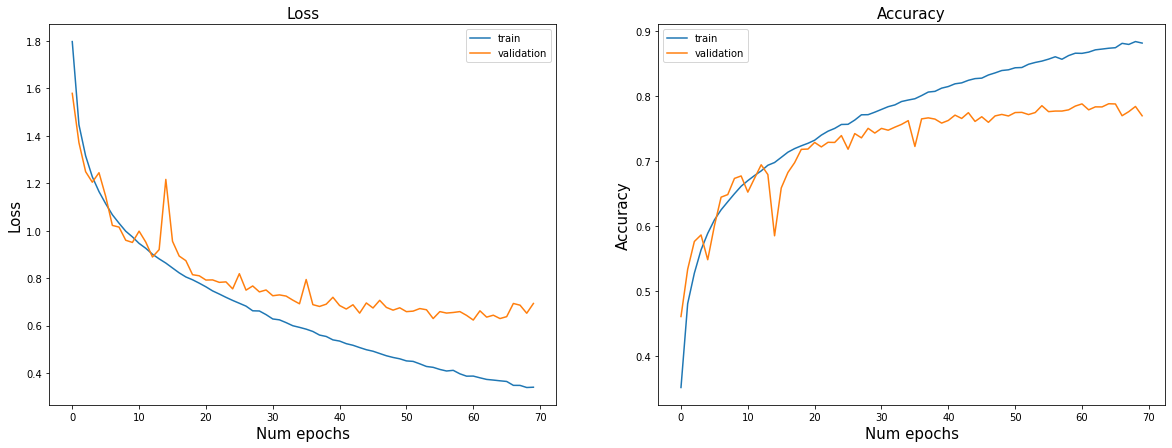

In [10]:
model = SimpleConvNet().cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, 
    train_loader, val_loader, 
    num_epochs=70
)

In [18]:
def test_eval(model,test_loader):

  model.eval()
  total_loss = 0
  test_acc = 0

  with torch.no_grad():
    for X_batch,Y_batch in test_loader:
      
      X_batch,Y_batch = X_batch.cuda(),Y_batch.cuda()
      test_loss = criterion(model(X_batch),Y_batch.long().cuda())
      total_loss += np.sum(test_loss.cpu().numpy())

      y_pred = model(X_batch).max(1)[1].cpu().numpy()
      test_acc += np.mean(Y_batch.cpu().numpy() == y_pred)

    avg_loss = total_loss/(len(test_loader))
    avg_acc = test_acc/(len(test_loader)) 
  
  return avg_loss, avg_acc


In [19]:
test_eval(model,test_loader)

(0.6867357380450911, 0.765625)

Thus, one can see that our model is able to get 77% accuracy on test dataset.

In [30]:
filters_1 = model.conv1.weight.detach().cpu().reshape(32*3,3,3)
filters_2 = model.conv2.weight.detach().cpu().reshape(64*32,3,3)

norms_1 = torch.linalg.norm(filters_1,dim=(-2,-1))
norms_2 = torch.linalg.norm(filters_2,dim=(-2,-1))
norms = list()
norms.extend([norms_1,norms_2])

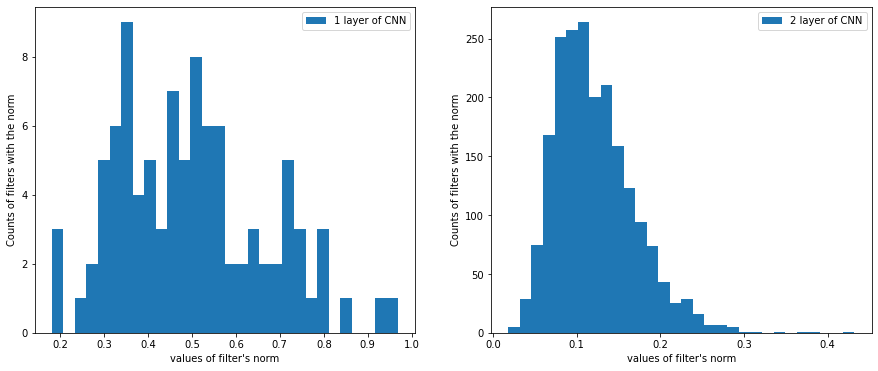

In [31]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax = ax.flatten()
for idx in range(2):
  ax[idx].hist(norms[idx], density=False, bins=30,label= str(idx + 1) + " layer of CNN") 
  ax[idx].set_ylabel('Counts of filters with the norm')
  ax[idx].set_xlabel("values of filter's norm")
  ax[idx].legend()
plt.show();